In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
from sklearn.metrics import auc,roc_curve

import matplotlib.pyplot as plt
%matplotlib inline

import heapq
from random import random,randint

nrows = 15000

In [5]:
#linux_file = "../data/min_max_train.csv"
mac_file = "../data/train.csv"

train = pd.read_csv(mac_file,nrows=nrows)
train.drop('ID_code',inplace= True,axis=1)

In [6]:
train_data, test_data = train_test_split(train,test_size = 0.3)

In [7]:
def sub_sample(label_1,label_0,low_class_ratio):
    res = pd.DataFrame(label_1)
    n = int(res.shape[0] / low_class_ratio) - res.shape[0]
    samples = label_0.sample(n = n)
    res = res.append(samples)
    return(res)

def smte(label_1,label_0,N=5,k = 8):
    res = pd.DataFrame(label_0)
    res = res.append(label_1)
    
    selected_sample = label_1

    nrows = selected_sample.shape[0]
    ncols = label_1.shape[0]

    dis = [[0 for j in range(ncols)] for i in range(nrows)]
    added_df = pd.DataFrame()

    for i in range(nrows):
        knn = []
        for j in range(ncols):
            if i == j:
                continue
            dis = selected_sample.iloc[i,1:].dot(label_1.iloc[j,1:])
            if len(knn) >= k:
                heapq.heappushpop(knn,(-dis,j))
            else:
                heapq.heappush(knn,(-dis,j))

        for j in range(N):
            nn = label_1.iloc[knn[randint(0,len(knn)-1)][1],1:]

            create_sample = selected_sample.iloc[i,1:] + random() * (nn - selected_sample.iloc[i,1:])
            added_df = added_df.append(create_sample,ignore_index=True)

    added_df['target'] = 1
    res = res.append(added_df)
    return(res)
    

def data_augmentation(train,method = 'smte',**param):
    data_1 = train[train['target'] == 1]
    data_0 = train[train['target'] == 0]
    if method == 'sub_sample':
        return(sub_sample(data_1,data_0,**param))
    elif method == 'smte':
        return (smte(data_1,data_0,**param))
    elif method == 'none':
        return(train)

In [8]:
def plotGraph(df):
    predicts_list = df.columns[1:]
    aucs = pd.DataFrame(columns=['models','auc_score'])
    y = df['label']
    for res in predicts_list:
        fpr,tpr,thres = roc_curve(y,df[res])
        auc_score = auc(fpr,tpr)
        aucs = aucs.append({'models':res,'auc_score':auc_score},ignore_index=True)
        
        plt.plot(fpr,tpr,lw=1, alpha=0.3,label = res+' : '+str(round(auc_score,3)))
    
    plt.legend(loc='lower right')
    plt.show()
    return(aucs)

In [ ]:
aug_train_data = data_augmentation(train_data,method='smte',N=1,k=5)
#aug_train_data = pd.read_csv("../data/aug_test.csv")

In [ ]:
#aug_train_data.to_csv('../data/aug_test.csv',index=False)
aug_train_data.head()

In [ ]:
lr = LogisticRegression()
test_x = test_data.drop('target',axis=1)
test_y = test_data['target']

In [ ]:
org_train_x = train_data.drop('target',axis=1)
org_train_y = train_data['target']
org_test = lr.fit(org_train_x,org_train_y).predict_proba(test_x)[:,1]

aug_train_x = aug_train_data.drop('target',axis=1)
aug_train_y = aug_train_data['target']
aug_test = lr.fit(aug_train_x,aug_train_y).predict_proba(test_x)[:,1]

In [ ]:
result_df = pd.DataFrame()
result_df['label'] = test_data['target']
result_df['base'] = org_test
result_df['aug'] = aug_test

In [ ]:
plotGraph(result_df)

In [181]:
demo = []
for i in range(5):
    demo.append({
        'target':1,
        'var_0':randint(0,5),
        'var_1':randint(-5,0)
    })
    demo.append({
        'target':0,
        'var_0':randint(-5,0),
        'var_1':randint(0,5)
    })

demo_df = pd.DataFrame(demo)

In [182]:
x = demo_df.drop('target',axis=1)
y = demo_df['target']

In [183]:
def plot(x,y):
    plt.scatter(x.iloc[:,0],x.iloc[:,1],c=y,cmap="copper_r")
    plt.colorbar()
    plt.show()

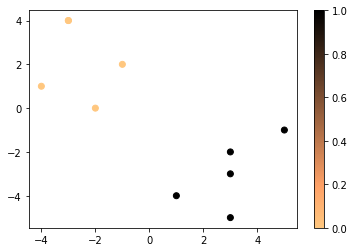

In [184]:
plot(x,y)

In [188]:
smote_data = smte(demo_df[demo_df.target == 1],demo_df[demo_df.target == 0],N=1,k=2)

In [189]:
s_x = smote_data.drop('target',axis=1)
s_y = smote_data['target']

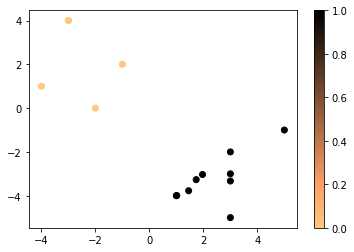

In [190]:
plot(s_x,s_y)

,target,var_0,var_1
38,1,8.67584,-5.935168


In [123]:
result_df['aug'].describe()

count    4500.000000
mean        0.013262
std         0.029902
min         0.000011
25%         0.001172
50%         0.003674
75%         0.011767
max         0.522882
Name: aug, dtype: float64

In [124]:
result_df['base'].describe()

count    4500.000000
mean        0.097558
std         0.147532
min         0.000189
25%         0.013319
50%         0.038419
75%         0.109618
max         0.959320
Name: base, dtype: float64

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
